In [2]:
import numpy as np
import neurokit2 as nk
from scipy import integrate
import pickle

# acceleration
def acc(speed, time):
    return np.gradient(speed, time, edge_order=2)

# motion sickness dose value
def msdv_eq(speed, time):
    return np.sqrt(integrate.cumtrapz(acc(speed, time)**2, time, initial=0))

# peaks
def find_peaks(gsr):
    decomposed_eda = nk.eda_process(gsr, sampling_rate=4)[0]
    eda_interval = nk.eda_intervalrelated(decomposed_eda, sampling_rate=4)
    num_of_peaks = eda_interval["SCR_Peaks_N"]
    return sum(num_of_peaks)

# load data
data_path = './data/raw_data2020.p'
dataPoolfont_sizefont_size = pickle.load(open(data_path, "rb"))

num_of_samples = len(list(dataPoolfont_sizefont_size.keys()))
# num_of_samples = 1
num_of_interval = 30

figsize = (15, 10)

input_list = []
output_list = []

for j in range(num_of_samples):
    name = list(dataPoolfont_sizefont_size.keys())[j]
    one_sample = dataPoolfont_sizefont_size[name]
    time_speed = one_sample.Steam.rawSpeed.Time
    raw_speed = one_sample.Steam.rawSpeed.Speed
    GSR = one_sample.Empatica.GSR
    time_eda = one_sample.Empatica.GSR.Time
    one_sample_input = []
    one_sample_output = []
    
    # adjust time scale
    t = np.arange(0, 0.25*len(GSR), 0.25)
    t_difference = t[-1] - time_speed.iloc[-1]
    if t_difference >= 0:
        countTimeInZero = int(t_difference/0.25)
        timeBase = t[countTimeInZero]
        t -= timeBase
    GSR.E4_Time = t
    GSR = GSR.drop(GSR[GSR.E4_Time < 0].index)
    GSR.reset_index(drop=True, inplace=True)
    
    # Peaks
    # method = neurokit / biosppy
    decomposed_eda = nk.eda_process(GSR.GSR, sampling_rate=4)[0]
    step = int(len(GSR.GSR) / num_of_interval)
    peaks_list = []
    piece_gsr = []
    for i in range(0, len(GSR.GSR), step):
        if len(GSR.GSR[i: i+step]) < step:
            eda_interval = nk.eda_intervalrelated(decomposed_eda[i-step:], 
                                                  sampling_rate=4)
            peaks_list[-1] = eda_interval["SCR_Peaks_N"].values
            piece_gsr[-1] = decomposed_eda["EDA_Raw"][i-step:].values
            # piece_gsr[-1] = decomposed_eda["EDA_Phasic"][i-step:].values
        else:
            eda_interval = nk.eda_intervalrelated(decomposed_eda[i: i+step], 
                                                  sampling_rate=4)
            peaks_list.append(eda_interval["SCR_Peaks_N"].values)
            piece_gsr.append(decomposed_eda["EDA_Raw"][i: i+step].values)
            # piece_gsr.append(decomposed_eda["EDA_Phasic"][i: i+step].values)

    # MSDV
    msdv_list = []
    step = int(len(time_speed) / num_of_interval)
    speed_list = []
    for i in range(0, len(raw_speed), step):
        if len(raw_speed[i: i+step]) < step:
            speed_list[-1] = raw_speed[i-step:].values
            msdv_list[-1] = msdv_eq(raw_speed[i-step:], time_speed[i-step:])
        else:
            speed_list.append(raw_speed[i: i+step].values)
            msdv_list.append(msdv_eq(raw_speed[i: i+step], time_speed[i: i+step]))
    
    input_list.append([name, speed_list, piece_gsr]) # INPUT
    output_list.append([name, msdv_list, peaks_list]) # OUTPUT

merged_input_list = []
merged_output_list = []
for i in range(num_of_samples):
    # remove group name
    input_list[i][0] = input_list[i][0].split("group")[0]
    input_list[i][0] = input_list[i][0].split("gift")[0]
    output_list[i][0] = output_list[i][0].split("group")[0]
    output_list[i][0] = output_list[i][0].split("gift")[0]
# merge info
skip_step, pivot = 0, 0
for i in range(num_of_samples):
    name = input_list[pivot][0]
    tmp_speed = input_list[pivot][1]
    tmp_gsr = input_list[pivot][2]
    tmp_msdv = output_list[pivot][1]
    tmp_peaks = output_list[pivot][2]
    matched = False
    for j in range(pivot+1, num_of_samples, 1):
        if name == input_list[j][0]:
            tmp_speed = tmp_speed + input_list[j][1]
            tmp_gsr = tmp_gsr + input_list[j][2]
            tmp_msdv = tmp_msdv + output_list[j][1]
            tmp_peaks = tmp_peaks + output_list[j][2]
            skip_step = j
            matched = True
    merged_input_list.append([name, tmp_speed, tmp_gsr])
    merged_output_list.append([name, tmp_msdv, tmp_peaks])
    if matched:
        pivot = skip_step+1
    else:
        pivot += 1
    if pivot >= num_of_samples:
        break

# file_name = './peaks/data0_BingHan4.txt'
# with open(file_name, 'wb') as fp:
#     pickle.dump(merged_output_list[4][2], fp)

file_name = 'input.txt'
with open(file_name, 'wb') as fp:
    pickle.dump(merged_input_list, fp)

# 120 trails: 'BingHan'4, 'Cunbo'7, 'Guanzhi'12, 'Lingfeng'26, 'Minghui'31, 'Olaf'32,
#                'Qichen'34, 'Wenzhe'40, 'Xinrui'43, 'Zhilong'51, 'Zihan'52

index = 52
action, msdv, sickness_level = [], [], []
# bound = [speed, msdv, sickness_level(1), sickness_level(2), sickness_level(3)]
bound = [1, 0.8, 0.1, 2.5, 4]
for i in range(120):
    # speed <=> action
    if np.mean(merged_input_list[index][1][i]) < bound[0]:
        action.append(0)
    else:
        action.append(1)
    # msdv <=> reward 
    if np.mean(merged_output_list[index][1][i]) < bound[1]:
        msdv.append(0)
    else:
        msdv.append(1)
    # true sickness level
    average = np.mean(merged_input_list[index][2][i])
    if average <= bound[2]:
        sickness_level.append(0.1)
    elif bound[2] < average <= bound[3]:
        sickness_level.append(0.4)
    elif bound[3] < average <= bound[4]:
        sickness_level.append(0.6)
    else:
        sickness_level.append(0.9)
    
action = np.double(action)
msdv = np.double(msdv)
# save as .mat file
import scipy     
Data = {'action': action, 'reward': msdv}
scipy.io.savemat('Data.mat', Data_0, oned_as='column')
Data = {"level": sickness_level}
scipy.io.savemat("Sickness_level.mat", Data, oned_as='row')




/Users/davidzhan/anaconda3/envs/ML1/lib/python3.11/site-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/Users/davidzhan/anaconda3/envs/ML1/lib/python3.11/site-packages/neurokit2/eda/eda_intervalrelated.py:116: RuntimeWarning: Mean of empty slice
  output["SCR_Peaks_Amplitude_Mean"] = np.nanmean(data[peaks_idx]["SCR_Amplitude"].values)
/var/folders/gk/z87t1wqx4p300dbsfbpqs4tw0000gn/T/ipykernel_41319/1829097846.py:12: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  return np.sqrt(integrate.cumtrapz(acc(speed, time)**2, time, initial=0))
/Users/davidzhan/anaconda3/envs/ML1/lib/python3.11/site-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/var/folders/gk/z87t1wqx4p300dbsfbpqs4tw0000gn/T/ipykernel_41319/1829097846.py:12: De

NameError: name 'Data_0' is not defined

In [2]:
import pandas as pd
import numpy as np

In [3]:
df_output = pd.DataFrame(merged_output_list,columns=['tester', 'tmp_msdv', 'peaks'])
df_output

,tester,tmp_msdv,peaks
0,Andreas,"[[0.0, 10.235038632014964, 14.073332389627016,...","[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [2...."
1,Anjela,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0], [0.0], [0.0], [1.0], [0.0], [0.0], [1...."
2,Anne,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[4.0], [7.0], [5.0], [4.0], [6.0], [4.0], [6...."
3,Aron,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0], [4.0], [5.0], [3.0], [5.0], [6.0], [3...."
4,BingHan,"[[0.0, 3.154252773752122, 3.7037348249875524, ...","[[2.0], [2.0], [1.0], [0.0], [2.0], [1.0], [1...."
5,Bowen,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[5.0], [5.0], [4.0], [4.0], [4.0], [6.0], [5...."
6,Chenyang,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[2.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1...."
7,Cunbo,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[4.0], [5.0], [5.0], [5.0], [6.0], [5.0], [6...."
8,Danfo,"[[0.0, 6.530872954118741, 7.6432728994553365, ...","[[0.0], [1.0], [0.0], [0.0], [0.0], [1.0], [0...."
9,Emilio,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[3.0], [4.0], [7.0], [6.0], [7.0], [6.0], [6...."


In [4]:
df_input = pd.DataFrame(merged_input_list,columns=['tester', 'speed', 'gsr'])

In [5]:
a = df_input['gsr'][0][0]

In [27]:
import matplotlib.pyplot as plt
import neurokit2 as nk
import pandas as pd

def find_peaks(gsr):
    # Process GSR signal
    decomposed_eda = nk.eda_process(gsr, sampling_rate=4)[0]
    eda_interval = nk.eda_intervalrelated(decomposed_eda, sampling_rate=4)
    num_of_peaks = eda_interval["SCR_Peaks_N"]
    
    # Plotting
    plt.figure(figsize=(15, 5))
    plt.plot(decomposed_eda['EDA_Raw'], label='Raw EDA', color='lightgrey')
    plt.plot(decomposed_eda['EDA_Tonic'], label='Tonic EDA', color='blue')
    plt.plot(decomposed_eda['EDA_Phasic'], label='Phasic EDA', color='red')
    
    # Marking peaks where SCR_Peaks equals 1
    peaks = decomposed_eda['SCR_Peaks']
    peak_indices = peaks[peaks == 1].index
    plt.plot(peak_indices, decomposed_eda['EDA_Raw'][peak_indices], "x", label="SCR Peaks", color='black')
    
    plt.title("Electrodermal Activity (EDA) with Identified Peaks")
    plt.xlabel("Samples")
    plt.ylabel("EDA (µS)")
    plt.legend()
    plt.savefig('EDA/peaks.png')
    plt.show()
    
    return sum(num_of_peaks), pd.DataFrame(decomposed_eda)


/Users/davidzhan/anaconda3/envs/ML1/lib/python3.11/site-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/Users/davidzhan/anaconda3/envs/ML1/lib/python3.11/site-packages/neurokit2/eda/eda_peaks.py:127: RuntimeWarning: All-NaN slice encountered
  info["SCR_Peaks"] > np.nanmin(info["SCR_Onsets"]), ~np.isnan(info["SCR_Onsets"])
/Users/davidzhan/anaconda3/envs/ML1/lib/python3.11/site-packages/neurokit2/eda/eda_intervalrelated.py:116: RuntimeWarning: Mean of empty slice
  output["SCR_Peaks_Amplitude_Mean"] = np.nanmean(data[peaks_idx]["SCR_Amplitude"].values)


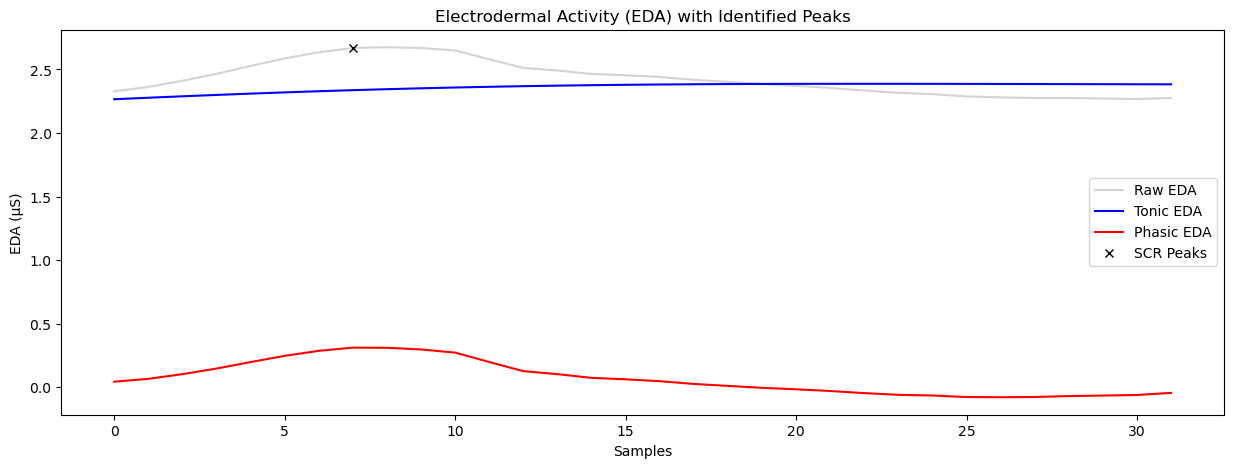

1.0

In [28]:
# SCR (Skin Conductance Response) peaks represent the instantaneous and significant increase in skin conductance,
# typically in response to physiological or emotional stimuli. In electrodermal activity (EDA) analysis, 
# SCR peaks reflect an individual's response intensity to external events. 
# These peaks are usually caused by a notable rise in skin conductance following a stimulus

x, y = find_peaks(a)
x

In [38]:
y

,EDA_Raw,EDA_Clean,EDA_Tonic,EDA_Phasic,SCR_Onsets,SCR_Peaks,SCR_Height,SCR_Amplitude,SCR_RiseTime,SCR_Recovery,SCR_RecoveryTime
0,2.327969,2.327969,2.266053,0.043970,0,0,0.000000,0.0,0.0,0,0.0
1,2.362554,2.362554,2.277723,0.066404,0,0,0.000000,0.0,0.0,0,0.0
2,2.411230,2.411230,2.289000,0.103386,0,0,0.000000,0.0,0.0,0,0.0
3,2.466311,2.466311,2.299815,0.147309,0,0,0.000000,0.0,0.0,0,0.0
4,2.527796,2.527796,2.310104,0.198246,0,0,0.000000,0.0,0.0,0,0.0
5,2.586720,2.586720,2.319809,0.247303,0,0,0.000000,0.0,0.0,0,0.0
6,2.635396,2.635396,2.328882,0.286853,0,0,0.000000,0.0,0.0,0,0.0
7,2.668700,2.668700,2.337284,0.311825,0,1,0.311825,NaN,NaN,0,0.0
8,2.675105,2.675105,2.344986,0.310733,0,0,0.000000,0.0,0.0,0,0.0
9,2.668700,2.668700,2.351973,0.297697,0,0,0.000000,0.0,0.0,0,0.0


### Explanation of Each Data Component and Calculation Method

#### Raw EDA (Electrodermal Activity)
The raw EDA signal captures the fluctuations in skin conductance, typically measured in microsiemens (\(\mu S\)). This signal directly reflects changes in skin conductance and is the foundation for subsequent computations. It is obtained directly from the sensors measuring skin conductance.

#### Tonic EDA
Tonic EDA represents the long-term baseline level of skin conductance, indicating overall trends in skin conductance levels. This is a low-frequency component obtained by applying a **low-pass filter** to the raw EDA signal. A low-pass filter allows signals with a frequency lower than a certain cutoff frequency to pass through while attenuating frequencies higher than the cutoff. The formula can be expressed as:

$$ \text{Tonic EDA} = \text{Low-pass filter}(\text{Raw EDA}) $$

In `NeuroKit2`, this component is derived by smoothing or decomposing the raw signal.

#### Phasic EDA
Phasic EDA reflects : $\textbf{rapid, transient changes in skin conductance, often associated with responses to specific stimuli or emotional reactions.}$ This high-frequency component is obtained by subtracting the tonic component from the raw EDA signal, which can be expressed as:

$$
\text{Phasic EDA} = \text{Raw EDA} - \text{Tonic EDA}
$$

A **high-pass filter** is used to isolate this component, allowing frequencies higher than the cutoff frequency to pass while attenuating lower frequencies. In `NeuroKit2`, the `eda_process` function automatically computes this by separating the raw signal into its tonic and phasic components.

#### SCR Peaks (Skin Conductance Response Peaks)
SCR Peaks represent the significant peaks in the phasic EDA component, indicating notable physiological responses to specific events. The detection process includes:

1. **Signal Decomposition**: Extracting the phasic EDA from the raw signal.
2. **Peak Detection**: Applying a peak detection algorithm to identify prominent local maxima in the phasic EDA signal, which correspond to sudden increases in skin conductance.

In `NeuroKit2`, these peaks are automatically detected and calculated using the `eda_process` and `eda_findpeaks` functions. The peaks indicate significant physiological reactions that can be used to study responses to stimuli or emotional changes.
